In [55]:
import upsetplot
from upsetplot import UpSet
from upsetplot import from_memberships
from upsetplot import plot
from matplotlib import cm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [56]:
! conda list -n upsetplot | tail -n +3

# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
asttokens                 2.2.1                    pypi_0    pypi
backcall                  0.2.0                    pypi_0    pypi
brotli                    1.0.9                h166bdaf_8    conda-forge
brotli-bin                1.0.9                h166bdaf_8    conda-forge
bzip2                     1.0.8                h7f98852_4    conda-forge
ca-certificates           2022.12.7            ha878542_0    conda-forge
certifi                   2022.12.7          pyhd8ed1ab_0    conda-forge
comm                      0.1.2                    pypi_0    pypi
contourpy                 1.0.7           py311ha3edf6b_0    conda-forge
cycler                    0.11.0             pyhd8ed1ab_0    conda-forge
debugpy                   1.6.6                    pypi_0    pypi
decorator   

In [89]:
#import the feature tables from benga_hostgenotyoe.ipynb
res_gut = pd.read_csv("res_gut.tsv", sep="\t").set_index("Unnamed: 0").astype(int)
res_skin = pd.read_csv("res_skin.tsv", sep="\t").set_index("Unnamed: 0").astype(int)

In [90]:
#import taxa from benga_hostgenotyoe.ipynb
res_gut_taxa = pd.read_csv("res_gut_taxa.tsv", sep="\t").set_index("Feature ID")
res_skin_taxa = pd.read_csv("res_skin_taxa.tsv", sep="\t").set_index("Feature ID")

In [91]:
#import metadata from benga_hostgenotyoe.ipynb
meta_gut = pd.read_csv("meta_gut.tsv", sep="\t").set_index("Unnamed: 0")
meta_skin = pd.read_csv("meta_skin.tsv", sep="\t").set_index("Unnamed: 0")

In [112]:
#adding int to generation to properly list generations in upsetplots
conditions = [
    (meta_gut["generation"] == "RM"),
    (meta_gut["generation"] == "P"),
    (meta_gut["generation"] == "F1"),
    (meta_gut["generation"] == "F2"),
    (meta_gut["generation"] == "F3"),
    (meta_gut["generation"] == "F4"),
    (meta_gut["generation"] == "F5")
]

values = ["-1: RM", "0: P", "1: F1", "2: F2", "3: F3", "4: F4", "5: F5"]
meta_gut["i_gen"] = np.select(conditions, values, "other")
conditions = [
    (meta_skin["generation"] == "RM"),
    (meta_skin["generation"] == "P"),
    (meta_skin["generation"] == "F1"),
    (meta_skin["generation"] == "F2"),
    (meta_skin["generation"] == "F3"),
    (meta_skin["generation"] == "F4"),
    (meta_skin["generation"] == "F5")
]

values = ["-1: RM", "0: P", "1: F1", "2: F2", "3: F3", "4: F4", "5: F5"]
meta_skin["i_gen"] = np.select(conditions, values, "other")

In [93]:
def pick_rank(counts, taxa, rank):
    #split information in taxa table per rank and assign proper names to each column
    taxa_split = taxa["Taxon"].str.split(pat=";", expand=True)
    taxa_split = taxa_split.rename(columns={0: "domain", 1: "phylum", 2: "class", 3: "order", 4: "family", 5: "genus", 6: "species"})
    #copy counts DataFrame to avoid chagnes being made to imported feature tables
    taxa_counts = counts.copy()
    taxa_counts[rank] = taxa_split[rank]
    #grouping taxa by rank, collapsing feature tables
    grouped_counts = taxa_counts.groupby(rank).sum()
    return(grouped_counts)

def make_upset(counts, meta, category,plotname, taxa=None, rank=None):
    #if rank is give, collapse feature table to rank, else process ASVs
    if rank != None:
        upset = pick_rank(counts, taxa, rank)
        upset = upset.transpose()
    else:
        upset = counts.transpose()
    #adding category to feature table + control to filter out control samples
    upset[category] = meta[category]
    upset['control'] = meta['control']
    upset = upset.drop(upset[upset['control'].isin(["Duesseldorf","Janvier"])].index)
    #grouping by category and omitting taxa not present in all samples
    upset_grouped = upset.groupby(category).sum()
    upset_grouped = upset_grouped.loc[:, (upset_grouped != 0).any(axis=0)]
    #assign boolean values of True/False depending on whether values are > 0 or not, combining with the actual values and assigning the boolean columns as indeces
    upset_grouped = upset_grouped.transpose()
    over_zero = upset_grouped > 0
    over_zero = over_zero.rename(columns=lambda x: x + ' ')
    upset_combined = pd.concat([upset_grouped, over_zero],axis=1)
    upset_combined = upset_combined.set_index(list(over_zero.columns))
    #plotting upsetplot with the plot() function
    plot(upset_combined, show_counts=True, subset_size="count", sort_categories_by="-input")
    plt.savefig(f"{plotname}.svg", transparent=False, bbox_inches='tight')
    plt.show()

## Figure S5

### Panel A: <span style="color:red">Anna</span>

/tmp/ipykernel_2408061/2047124503.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upset_grouped = upset.groupby(category).sum()


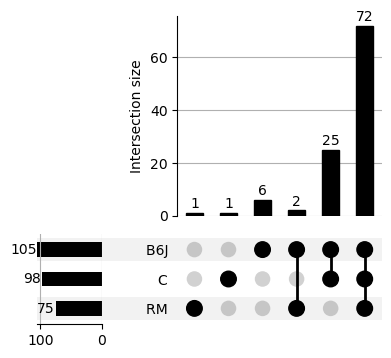

In [94]:
make_upset(res_gut, meta_gut, "host_genotype","S5panelA", res_gut_taxa, "genus")

### Panel B: <span style="color:red">Anna</span>

In [95]:
C_res_gut = res_gut[[col for col in list(meta_gut[meta_gut['host_genotype'].isin(['C'])].index) if col in res_gut.columns]]

/tmp/ipykernel_2408061/2047124503.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upset_grouped = upset.groupby(category).sum()


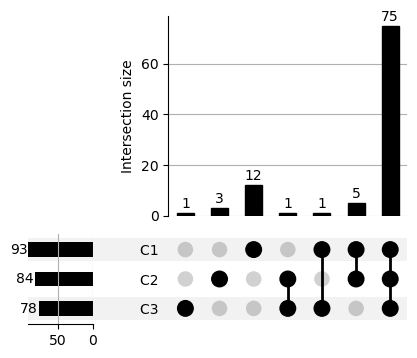

In [96]:
make_upset(C_res_gut, meta_gut, "cage_line", "S5panelB", res_gut_taxa, "genus")

### Panel C: <span style="color:red">Anna</span>

In [97]:
B6J_res_gut = res_gut[[col for col in list(meta_gut[meta_gut['host_genotype'].isin(['B6J'])].index) if col in res_gut.columns]]

/tmp/ipykernel_2408061/2047124503.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upset_grouped = upset.groupby(category).sum()


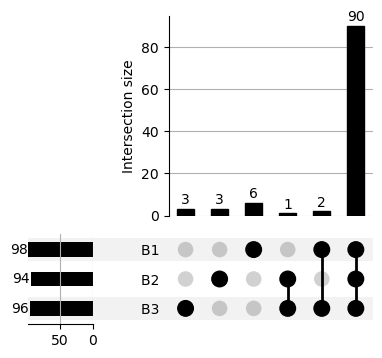

In [98]:
make_upset(B6J_res_gut, meta_gut, "cage_line","S5panelC", res_gut_taxa, "genus")

### Panel D: <span style="color:red">Anna</span>

In [99]:
CRM_res_gut = res_gut[[col for col in list(meta_gut[meta_gut['host_genotype'].isin(['C', 'RM'])].index) if col in res_gut.columns]]

/tmp/ipykernel_2408061/2047124503.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upset_grouped = upset.groupby(category).sum()


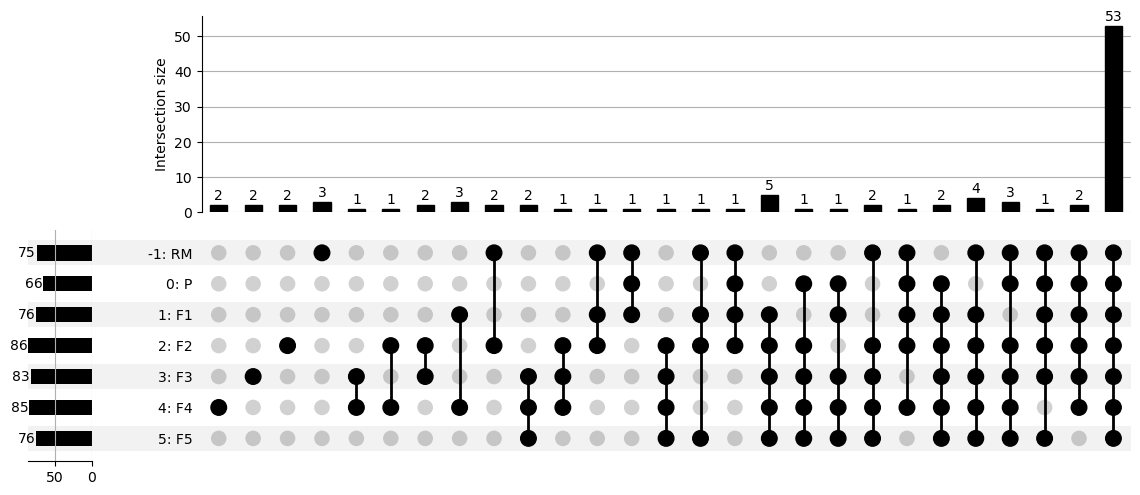

In [100]:
make_upset(CRM_res_gut, meta_gut, "i_gen","S5panelD", res_gut_taxa, "genus")

### Panel E: <span style="color:red">Anna</span>

In [101]:
B6JRM_res_gut = res_gut[[col for col in list(meta_gut[meta_gut['host_genotype'].isin(['B6J', 'RM'])].index) if col in res_gut.columns]]

/tmp/ipykernel_2408061/2047124503.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upset_grouped = upset.groupby(category).sum()


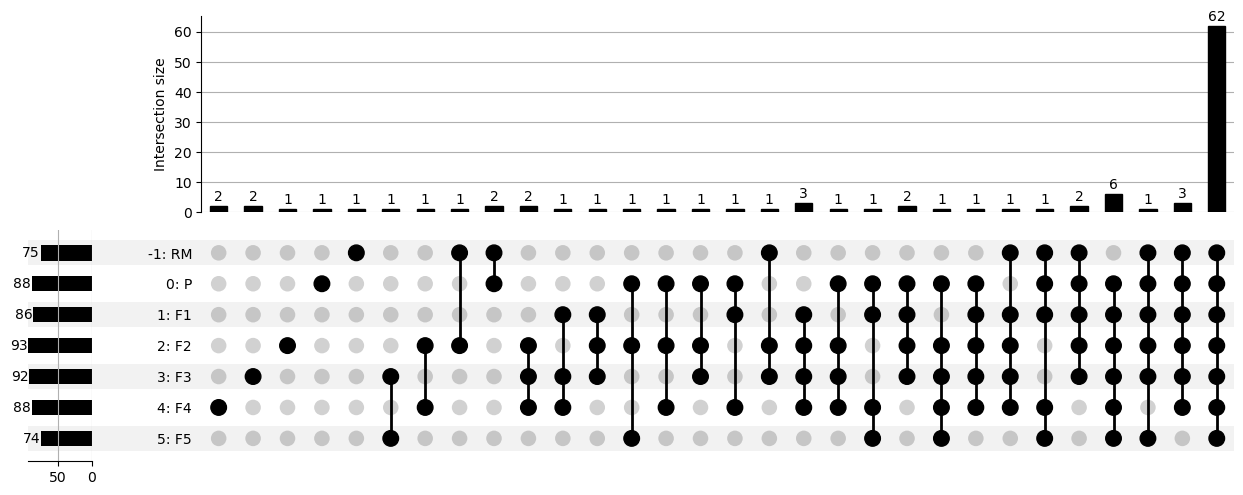

In [102]:
make_upset(B6JRM_res_gut, meta_gut, "i_gen","S5panelE", res_gut_taxa, "genus")

## Figure S6

### Panel A: <span style="color:red">Anna</span>

/tmp/ipykernel_2408061/2047124503.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upset_grouped = upset.groupby(category).sum()


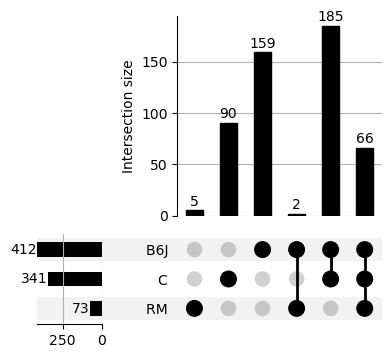

In [103]:
make_upset(res_skin, meta_skin, "host_genotype","S6panelA", res_skin_taxa, "genus")

### Panel B: <span style="color:red">Anna</span>

In [104]:
C_res_skin = res_skin[[col for col in list(meta_skin[meta_skin['host_genotype'].isin(['C'])].index) if col in res_skin.columns]]

/tmp/ipykernel_2408061/2047124503.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upset_grouped = upset.groupby(category).sum()


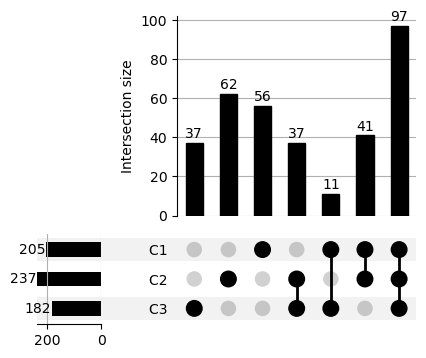

In [105]:
make_upset(C_res_skin, meta_skin, "cage_line", "S6panelB",res_skin_taxa, "genus")

### Panel C: <span style="color:red">Anna</span>

In [106]:
B6J_res_skin = res_skin[[col for col in list(meta_skin[meta_skin['host_genotype'].isin(['B6J'])].index) if col in res_skin.columns]]

/tmp/ipykernel_2408061/2047124503.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upset_grouped = upset.groupby(category).sum()


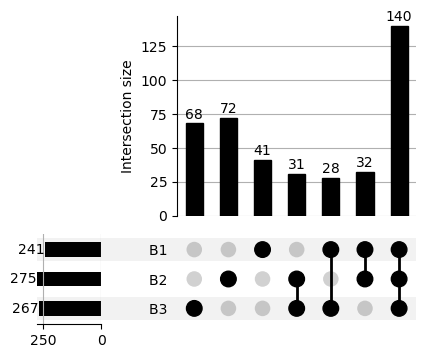

In [107]:
make_upset(B6J_res_skin, meta_skin, "cage_line","S6panelC", res_skin_taxa, "genus")

### Panel D: <span style="color:red">Anna</span>

In [108]:
CRM_res_skin = res_skin[[col for col in list(meta_skin[meta_skin['host_genotype'].isin(['C', 'RM'])].index) if col in res_skin.columns]]

/tmp/ipykernel_2408061/2047124503.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upset_grouped = upset.groupby(category).sum()


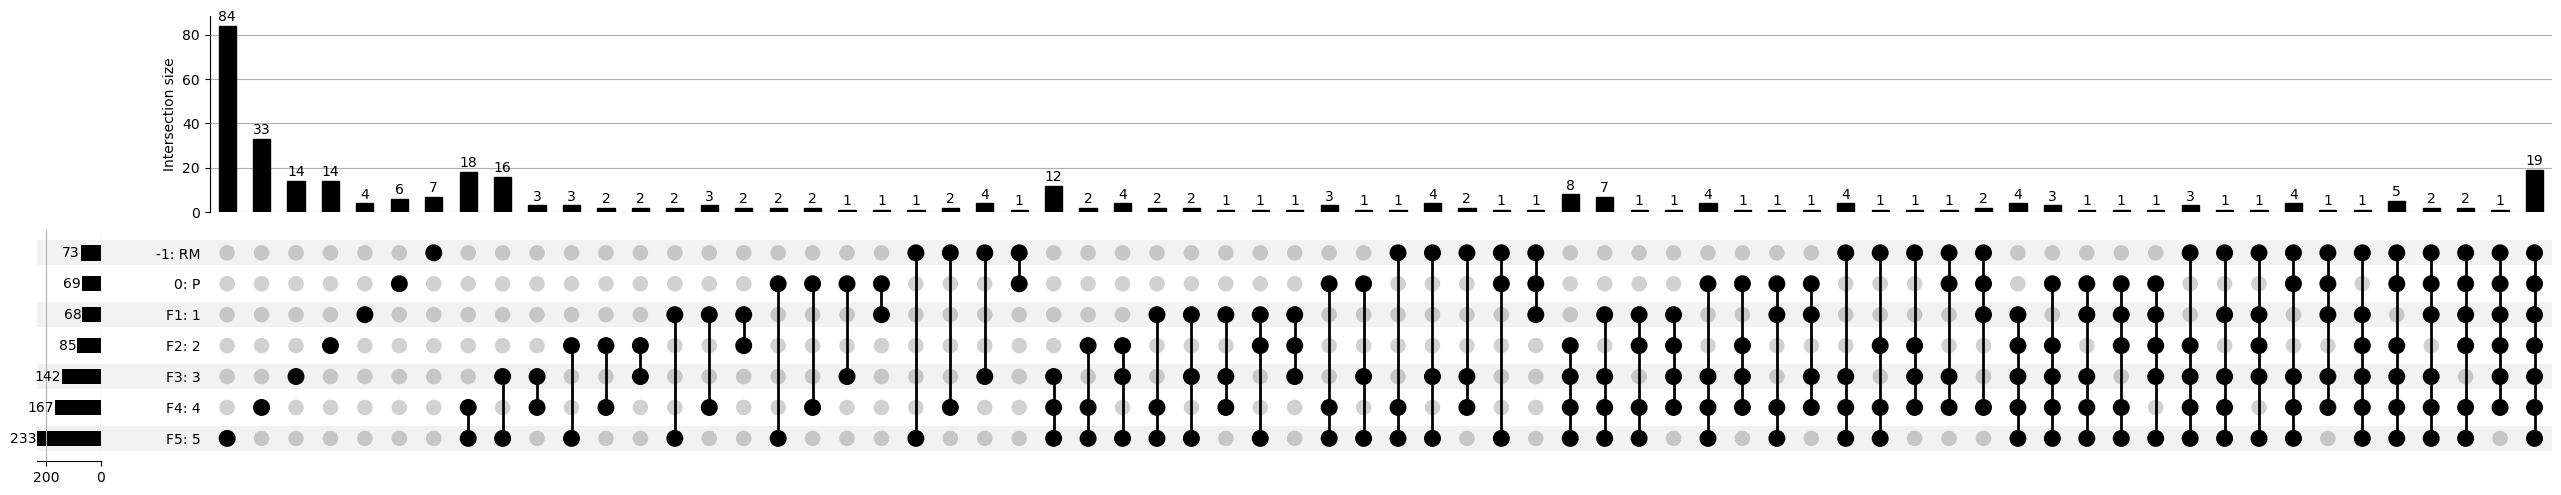

In [109]:
make_upset(CRM_res_skin, meta_skin, "i_gen", "S6panelD",res_skin_taxa, "genus")

### Panel E: <span style="color:red">Anna</span>

In [110]:
B6JRM_res_skin = res_skin[[col for col in list(meta_skin[meta_skin['host_genotype'].isin(['B6J', 'RM'])].index) if col in res_skin.columns]]

/tmp/ipykernel_2408061/2047124503.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upset_grouped = upset.groupby(category).sum()


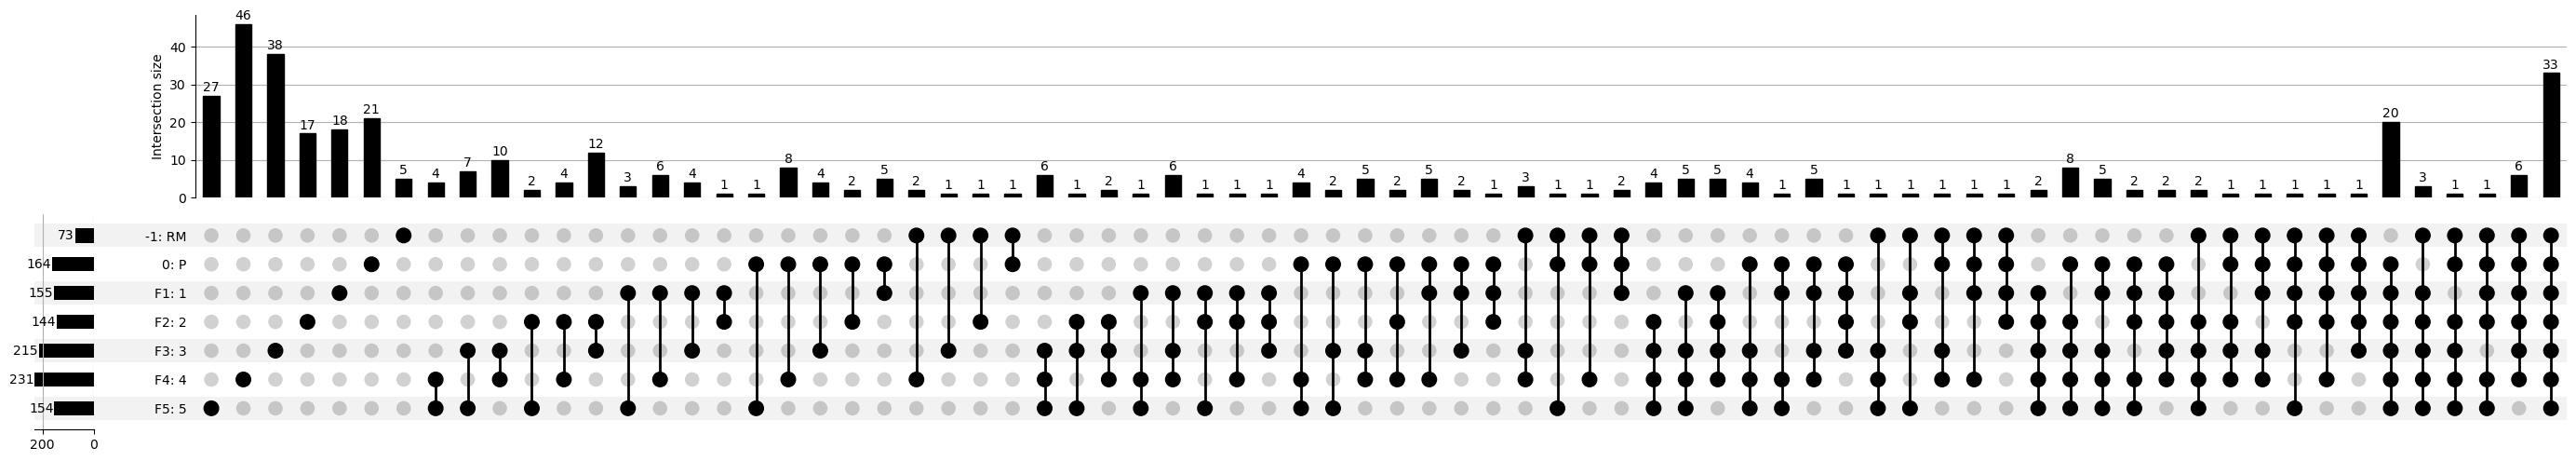

In [111]:
make_upset(B6JRM_res_skin, meta_skin, "i_gen", "S6panelE",res_skin_taxa, "genus")